In [ ]:
import torch
import torch.nn as nn
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
filePath = '/content/drive/Shareddrives/FYP/Data/SiTa Data/Extracted/combined.txt'# '/content/drive/Shareddrives/FYP/Data/cleanedAllNames.txt'
raw_data = open(filePath, encoding='utf-8').read()
lines = open(filePath, 'r', encoding='utf-8').readlines()
lines = [line.strip() for line in lines if len(line) > 1]
all_characters = list(set(raw_data))
n_characters = len(all_characters) + 1

In [ ]:
from random import random, randint

def train_test_split(data, fraction=0.6):
  n_train = int(len(data) * fraction)
  train = []
  test = []
  for i in range(n_train):
    x = n_train - 1 - i
    train.append(data.pop(randint(0, x)))
  
  return train, data

train_data, test_data = train_test_split(lines, fraction=0.6)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout_rate = dropout
    self.softmax = nn.LogSoftmax(dim=1)

    self.embed = nn.Embedding(input_size, hidden_size).to(device)
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=False).to(device)
    self.fc = nn.Linear(hidden_size, output_size).to(device)

  def forward(self, x, hidden, cell):
    embedding = self.embed(x)
    out, (hidden, cell) = self.lstm(embedding.unsqueeze(1), (hidden, cell))
    out = self.fc(out.reshape(out.shape[0], -1))
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    return hidden, cell


In [ ]:
num_epochs = 40
batch_size = 1
print_every = 10
hidden_size = 64
num_layers = 3
dropout = 0.4
lr = 0.003
model = RNN(n_characters, hidden_size, num_layers, n_characters, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
    return tensor

def get_name(n_i, data):
    name = data[n_i]
    chunk_len = len(name)
    text_input = torch.zeros(1, chunk_len)
    text_target = torch.zeros(1, chunk_len)

    text_input[0,:] = char_tensor(name)
    text_target[0,:] = torch.cat((char_tensor(name[1:]), torch.tensor([n_characters - 1])), 0)

    return text_input.long(), text_target.long(), chunk_len

def train(model, optimizer, criterion, num_epochs, train_data, batch_size):
  print('=> Starting training')
  all_losses = []
  total_loss = 0

  for epoch in range(1, num_epochs + 1):
    for n_i in range(len(train_data)):
      inp, target, chunk_len = get_name(n_i, train_data)
      hidden, cell = model.init_hidden(batch_size=batch_size)

      model.zero_grad()
      loss = 0
      inp = inp.to(device)
      target = target.to(device)

      for c in range(chunk_len):
        output, (hidden, cell) = model(inp[:, c], hidden, cell)
        loss += criterion(output, target[:, c])

      loss.backward()
      optimizer.step()

      perplexity  = torch.exp(loss)
      loss = loss.item() /chunk_len
      total_loss += loss
    
    print(f'Loss: {loss} Perplexity: {perplexity}')
    all_losses.append(total_loss)
    total_loss = 0
  import matplotlib.pyplot as plt
  import matplotlib.ticker as ticker

  plt.figure()
  plt.plot(all_losses)

def test(model, criterion, batch_size, test_data):

  print('=> Starting testing')
  all_losses = []
  total_loss = 0
  for n_i in range(len(test_data)):
    inp, target, chunk_len = get_name(n_i, test_data)
    hidden, cell = model.init_hidden(batch_size=batch_size)

    model.zero_grad()
    loss = 0
    inp = inp.to(device)
    target = target.to(device)

    for c in range(chunk_len):
      output, (hidden, cell) = model(inp[:, c], hidden, cell)
      loss += criterion(output, target[:, c])

    loss.backward()

    perplexity  = torch.exp(loss)
    loss = loss.item() /chunk_len
    total_loss += loss
    print(f'Loss: {loss} Perplexity: {perplexity}')
    all_losses.append(total_loss)
    total_loss = 0
  import matplotlib.pyplot as plt
  import matplotlib.ticker as ticker

  plt.figure()
  plt.plot(all_losses)

=> Starting training
Loss: 1.898574670155843 Perplexity: 88561.1015625
Loss: 2.0968411763509116 Perplexity: 290990.84375
Loss: 1.857213815053304 Perplexity: 69098.125
Loss: 2.284865697224935 Perplexity: 899140.125
Loss: 2.8301541010538735 Perplexity: 23698554.0
Loss: 1.4887844721476238 Perplexity: 7575.74365234375
Loss: 1.4458152453104656 Perplexity: 5854.064453125
Loss: 1.5531363487243652 Perplexity: 11145.80078125
Loss: 1.7577123641967773 Perplexity: 38035.4609375
Loss: 1.8796051343282063 Perplexity: 79033.796875
Loss: 1.6132381757100422 Perplexity: 15985.3671875
Loss: 1.7213964462280273 Perplexity: 30588.478515625
Loss: 1.656343142191569 Perplexity: 20703.517578125
Loss: 1.9874823888142903 Perplexity: 150978.75
Loss: 2.014054457346598 Perplexity: 177074.65625
Loss: 1.8025703430175781 Perplexity: 49782.6640625
Loss: 1.479439417521159 Perplexity: 7162.65869140625
Loss: 1.8708443641662598 Perplexity: 74986.7109375
Loss: 1.9885889689127605 Perplexity: 151984.5
Loss: 1.971100648244222 Pe

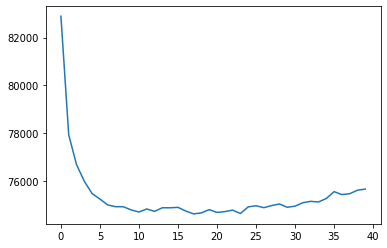

In [ ]:
train(model, optimizer, criterion, num_epochs, train_data, batch_size)

In [ ]:
test(model, criterion, batch_size, test_data)

Streaming output truncated to the last 5000 lines.
Loss: 2.4670310020446777 Perplexity: 7194744979456.0
Loss: 2.0477685928344727 Perplexity: 46991056896.0
Loss: 2.04757080078125 Perplexity: 21813759311872.0
Loss: 1.9999478658040364 Perplexity: 26472554496.0
Loss: 2.2243548075358075 Perplexity: 309296701112320.0
Loss: 2.3349918018687856 Perplexity: 142828404736.0
Loss: 2.30452028910319 Perplexity: 1023494062080.0
Loss: 4.139302730560303 Perplexity: 240663744479232.0
Loss: 1.7970284548672764 Perplexity: 384445664.0
Loss: 1.9458343187967937 Perplexity: 13828698112.0
Loss: 1.9080675670078822 Perplexity: 399286861824.0
Loss: 1.7207252184549968 Perplexity: 928148800.0
Loss: 2.4378177642822267 Perplexity: 38664110080.0
Loss: 2.439830780029297 Perplexity: 59547779596288.0
Loss: 2.5346748352050783 Perplexity: 3.2503447060217856e+16
Loss: 1.6891934321476862 Perplexity: 3442674944.0
Loss: 1.4703022241592407 Perplexity: 16470480896.0
Loss: 2.662240982055664 Perplexity: 8653253.0
Loss: 2.0850993262

In [ ]:
def generate(model, initial_str='භ', prediction_len=8, temperature=0.85):
  hidden, cell = model.init_hidden(batch_size=batch_size)
  initial_input = char_tensor(initial_str)
  predicted = initial_str

  for p in range(len(initial_str), - 1):
    _, (hidden, cell) = model(initial_input[p].view(1).to(device), hidden, cell)

  last_char = initial_input[-1]

  for p in range(prediction_len):
    output, (hidden, cell) = model(last_char.view(1).to(device), hidden, cell)
    output_dist = output.data.view(-1).div(temperature).exp()
    # top_char = torch.multinomial(output_dist, 1)[0]
    # print(top_char)
    top_char = torch.topk(output_dist, 1).indices[0]
    # print(top_char)
    if(top_char == n_characters - 1):
      predicted += '\n'
      break
    predicted_char = all_characters[top_char]
    predicted += predicted_char
    last_char = char_tensor(predicted_char)
  return predicted

In [ ]:
generate(model, initial_str='කුම', prediction_len=8, temperature=0.50)

In [ ]:
import datetime

In [ ]:
torch.save(model, f'/content/drive/Shareddrives/FYP/model-no-class-{num_epochs}-{num_layers}-combined-{datetime.datetime.now()}.pth')